# AI for Redistricting Final Project

## Oregon Data Cleaning

@authors: vcle, bpuhani

All data retrieved in March 2025: <br>
[2020 Population data](https://redistrictingdatahub.org/dataset/oregon-block-pl-94171-2020-by-table/): based on the decennial census at the Census Block level on 2020 Census Redistricting Data

[2020 County data](https://redistrictingdatahub.org/dataset/oregon-county-pl-94171-2020/): from 2020 Census Redistricting Data (P.L. 94-171) Shapefiles

[2020 election data](https://redistrictingdatahub.org/dataset/vest-2020-oregon-precinct-and-election-results/):  VEST 2020 Oregon precinct and election results

[2021 State Senate District plan](https://redistrictingdatahub.org/dataset/2021-oregon-state-senate-adopted-plan/): 2021 Oregon State Senate Approved Plan


<!-- Commented out 2018 Election data for now

[2018 election data](https://redistrictingdatahub.org/dataset/vest-2018-oregon-precinct-and-election-results/)**:**  VEST 2018 Oregon precinct and election results

-->

In [1]:
# imports
import geopandas as gpd
import maup
from maup import smart_repair
import time
import warnings
import matplotlib.pyplot as plt
from shapely.ops import unary_union

import utilities

In [17]:
maup.progress.enabled = True

warnings.filterwarnings('ignore')

start_time = time.time()

In [3]:
vest20_df_repaired_0 = None
vest20_df_repaired_1 = None
vest20_df_repaired_2 = None
vest20_df_repaired_3 = None

## Import and Explore the Data

#### Description of the data or_pl2020_b:
* P1. Race
* P2. Hispanic or Latino, and Not Hispanic or Latino by Race
* P3. Race for the Population 18 Years and Over
* P4. Hispanic or Latino, and Not Hispanic or Latino by Race for the Population 18 Years and Over
* P5. Group Quarters Population by Major Group Quarters Type
* H1. Occupancy Status

Taken from the [Documentation](https://www2.census.gov/programs-surveys/decennial/2020/technical-documentation/complete-tech-docs/summary-file/2020Census_PL94_171Redistricting_StatesTechDoc_English.pdf)

We are using the following data:
* P2
* P4

In [4]:
# Paths to the data
population_path = "or_data/or_pl2020_b/or_pl2020_p2_b.shp"
vap_path = "or_data/or_pl2020_b/or_pl2020_p4_b.shp"
vest20_path = "or_data/or_vest_20/or_vest_20.shp"
# vest18_path = "./or_data/or_vest_18/or_vest_18.shp" # currently not used
county_path = "or_data/or_pl2020_cnty/or_pl2020_cnty.shp"
sen_path = "or_data/or_sldu_2021/Senate_LC_Draft_2_-_Revised_.shp"

### Loading data
Loading the total population data

In [5]:
population_df = utilities.load_shapefile(population_path)

Loading shapefile from ./or_data/or_pl2020_b/or_pl2020_p2_b.shp...
Shapefile data loaded from cache.


Loading the voting age population data

In [6]:
vap_df = utilities.load_shapefile(vap_path)

Loading shapefile from ./or_data/or_pl2020_b/or_pl2020_p4_b.shp...
Shapefile data loaded from cache.


Loading the VEST 2020 election data

In [7]:
vest20_df = utilities.load_shapefile(vest20_path)

Loading shapefile from ./or_data/or_vest_20/or_vest_20.shp...
Shapefile data loaded from cache.


Loading the County data

In [8]:
county_df = utilities.load_shapefile(county_path)

Loading shapefile from ./or_data/or_pl2020_cnty/or_pl2020_cnty.shp...
Shapefile data loaded from cache.


Loading the approved 2021 State Senate District plan

In [9]:
sen_df = utilities.load_shapefile(sen_path)

Loading shapefile from ./or_data/or_sldu_2021/Senate_LC_Draft_2_-_Revised_.shp...
Shapefile data loaded from cache.


## Exploring the data
Column names of the data

In [12]:
print(population_df.columns)
print(vap_df.columns)
print(vest20_df.columns)
print(county_df.columns)
print(sen_df.columns)

Index(['GEOID20', 'SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'P0020001',
       'P0020002', 'P0020003', 'P0020004', 'P0020005', 'P0020006', 'P0020007',
       'P0020008', 'P0020009', 'P0020010', 'P0020011', 'P0020012', 'P0020013',
       'P0020014', 'P0020015', 'P0020016', 'P0020017', 'P0020018', 'P0020019',
       'P0020020', 'P0020021', 'P0020022', 'P0020023', 'P0020024', 'P0020025',
       'P0020026', 'P0020027', 'P0020028', 'P0020029', 'P0020030', 'P0020031',
       'P0020032', 'P0020033', 'P0020034', 'P0020035', 'P0020036', 'P0020037',
       'P0020038', 'P0020039', 'P0020040', 'P0020041', 'P0020042', 'P0020043',
       'P0020044', 'P0020045', 'P0020046', 'P0020047', 'P0020048', 'P0020049',
       'P0020050', 'P0020051', 'P0020052', 'P0020053', 'P0020054', 'P0020055',
       'P0020056', 'P0020057', 'P0020058', 'P0020059', 'P0020060', 'P0020061',
       'P0020062', 'P0020063', 'P0020064', 'P0020065', 'P0020066', 'P0020067',
       'P0020068', 'P0020069', 'P0020070', 'P0020071', 'P002

In [13]:
nr_of_districts = sen_df.shape[0]
print(f"Number of State Senate Seats in Oregon: {nr_of_districts}")

Number of State Senate Seats in Oregon: 30


The list of columns in the population data we are interested in:


In [14]:
pop_column_names = ['P0020001', 'P0020002', 'P0020005', 'P0020006', 'P0020007',
                    'P0020008', 'P0020009', 'P0020010', 'P0020011']

In [15]:
vap_column_names = ['P0040001', 'P0040002', 'P0040005', 'P0040006', 'P0040007',
                    'P0040008', 'P0040009', 'P0040010', 'P0040011']

## Cleaning the data
1. Change all the coordinate reference systems to the same one

In [10]:
population_df = population_df.to_crs(population_df.estimate_utm_crs())
vap_df = vap_df.to_crs(vap_df.estimate_utm_crs())
county_df = county_df.to_crs(county_df.estimate_utm_crs())
sen_df = sen_df.to_crs(sen_df.estimate_utm_crs())
vest20_df = vest20_df.to_crs(vest20_df.estimate_utm_crs())
# vest18_df = vest18_df.to_crs(vest18_df.estimate_utm_crs()) # currently not used

### Running MAUP Doctor

In [17]:
try:
    maup.doctor(population_df)
except Exception as e:
    print(f"Error in MAUP Doctor for population_df: {e}")

100%|██████████| 130807/130807 [04:14<00:00, 513.16it/s] 


In [18]:
try:
    maup.doctor(vap_df)
except Exception as e:
    print(f"Error in MAUP Doctor for vap_df: {e}")

100%|██████████| 130807/130807 [04:18<00:00, 505.53it/s] 


In [19]:
try:
    maup.doctor(county_df)
except Exception as e:
    print(f"Error in MAUP Doctor for county_df: {e}")

100%|██████████| 36/36 [00:00<00:00, 48.62it/s]


In [20]:
try:
    maup.doctor(sen_df)
except Exception as e:
    print(f"Error in MAUP Doctor for sen_df: {e}")

100%|██████████| 30/30 [00:00<00:00, 35.98it/s]


In [21]:
try:
    maup.doctor(vest20_df)
except Exception as e:
    print(f"\033[91mError in MAUP Doctor for vest20_df: {e}\033[0m")

Error in MAUP Doctor for vest20_df: TopologyException: side location conflict at 490660.17303404625 4943064.1817789217. This can occur if the input geometry is invalid.


The maup doctor failed for the 2020 election data with a TopologyException.
It got recommended to use the `smart_repair` function with `snap_precision=8` to fix the TopologyException.

### Running MAUP Smart Repair for 2020 election data

We want to compare the results when fitting into `county_df` vs `sen_df`,
The idea is, that espacially in highly dense regions multiple districts exists but it is all one county.
So the proposed districts should be more useful to fit the data in.

first we run `smart_repair` with:
* `snap_precision=8`, to get rid of the TopologyException.
* `nest_within_regions=county_df`, fit the data inside the counties

In [22]:
vest20_df_repaired_with_county_0 = smart_repair(
    vest20_df,
    snap_precision=8,
    nest_within_regions=county_df
)

100%|██████████| 36/36 [00:00<00:00, 49.01it/s]


Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.


100%|██████████| 36/36 [00:01<00:00, 21.30it/s]


Identifying overlaps...


100%|██████████| 28185/28185 [02:24<00:00, 195.45it/s]


Resolving overlaps and filling gaps...


100%|██████████| 36/36 [00:01<00:00, 19.11it/s]
Gaps to simplify in region 0: 99it [00:59,  1.66it/s]                        
Gaps to fill in region 0: 100%|██████████| 46/46 [00:06<00:00,  6.64it/s]


1 gaps in region 1 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 2: 100%|██████████| 45/45 [00:21<00:00,  2.07it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 3 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 4: 100%|██████████| 69/69 [00:11<00:00,  6.11it/s]


1 gaps in region 5 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 5: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]
Gaps to simplify in region 6: 165it [00:37,  4.35it/s]                         
Gaps to fill in region 6: 100%|██████████| 42/42 [00:03<00:00, 12.72it/s]
Gaps to simplify in region 7: 94it [02:00,  1.28s/it]                        
Gaps to fill in region 10: 100%|██████████| 62/62 [00:03<00:00, 15.73it/s]


1 gaps in region 11 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 11: 100%|██████████| 56/56 [00:05<00:00,  9.81it/s]


1 gaps in region 12 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 13: 100%|██████████| 26/26 [00:05<00:00,  4.47it/s]
Gaps to simplify in region 14: 234it [00:59,  3.92it/s]                         
Gaps to fill in region 17: 100%|██████████| 64/64 [00:12<00:00,  4.94it/s]


2 gaps in region 18 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 18: 100%|██████████| 21/21 [00:00<00:00, 33.25it/s]
Gaps to simplify in region 19: 403it [07:09,  1.07s/it]                          
Gaps to fill in region 21: 100%|██████████| 48/48 [00:04<00:00, 11.38it/s]
Gaps to simplify in region 22: 158it [00:20,  7.75it/s]                         
Gaps to fill in region 24: 100%|██████████| 61/61 [00:04<00:00, 14.77it/s]
Gaps to simplify in region 25: 551it [02:58,  3.08it/s]                         
Gaps to fill in region 26: 100%|██████████| 6/6 [00:00<00:00,  9.51it/s]


1 gaps in region 27 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 30: 100%|██████████| 21/21 [00:01<00:00, 20.38it/s]


1 gaps in region 31 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 31: 196it [07:38,  2.34s/it]                         
Gaps to fill in region 31: 100%|██████████| 198/198 [00:15<00:00, 12.91it/s]


1 gaps in region 32 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 32: 100%|██████████| 50/50 [00:02<00:00, 20.58it/s]


1 gaps in region 33 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 33: 606it [04:05,  2.47it/s]                         
Gaps to fill in region 34: 100%|██████████| 73/73 [00:03<00:00, 22.55it/s]


1 gaps in region 35 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 35: 100%|██████████| 43/43 [00:09<00:00,  4.71it/s]


In [23]:
vest20_df_repaired_with_sen_0 = smart_repair(
    vest20_df,
    snap_precision=8,
    nest_within_regions=sen_df
)

100%|██████████| 30/30 [00:00<00:00, 53.79it/s]


Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.


100%|██████████| 30/30 [00:02<00:00, 10.98it/s]


Identifying overlaps...


100%|██████████| 30431/30431 [02:56<00:00, 172.53it/s]


Resolving overlaps and filling gaps...


100%|██████████| 30/30 [00:02<00:00, 12.43it/s]


2 gaps in region 0 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 0: 100%|██████████| 64/64 [00:13<00:00,  4.90it/s]


2 gaps in region 1 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 1: 100%|██████████| 195/195 [00:27<00:00,  7.15it/s]


1 gaps in region 2 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 2: 100%|██████████| 27/27 [00:01<00:00, 14.54it/s]


6 gaps in region 3 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 3: 66it [00:52,  1.25it/s]                        
Gaps to fill in region 3: 100%|██████████| 17/17 [00:04<00:00,  4.22it/s]


2 gaps in region 4 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 4: 100%|██████████| 89/89 [00:10<00:00,  8.55it/s]


5 gaps in region 5 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 5: 521it [02:17,  3.78it/s]                         
Gaps to fill in region 5: 100%|██████████| 199/199 [00:16<00:00, 11.83it/s]


2 gaps in region 6 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 6: 324it [01:08,  4.73it/s]                         
Gaps to fill in region 6: 100%|██████████| 19/19 [00:05<00:00,  3.36it/s]


2 gaps in region 7 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 7: 100%|██████████| 47/47 [00:03<00:00, 14.03it/s]


2 gaps in region 8 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 8: 1089it [03:24,  5.32it/s]                          
Gaps to fill in region 8: 100%|██████████| 69/69 [01:49<00:00,  1.58s/it]


2 gaps in region 9 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 9: 116it [00:28,  4.05it/s]                         
Gaps to fill in region 9: 100%|██████████| 45/45 [00:08<00:00,  5.51it/s]


4 gaps in region 10 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 10: 66it [00:09,  7.03it/s]                        
Gaps to fill in region 10: 100%|██████████| 39/39 [00:01<00:00, 19.82it/s]


1 gaps in region 11 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 11: 100%|██████████| 258/258 [00:09<00:00, 28.00it/s]


4 gaps in region 12 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 12: 100%|██████████| 30/30 [00:01<00:00, 24.33it/s]


7 gaps in region 13 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 13: 100%|██████████| 28/28 [00:03<00:00,  7.59it/s]


3 gaps in region 14 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 14: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


3 gaps in region 15 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 15: 100%|██████████| 75/75 [00:04<00:00, 18.21it/s]


4 gaps in region 16 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 16: 100%|██████████| 14/14 [00:04<00:00,  3.30it/s]


3 gaps in region 17 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 17: 58it [00:34,  1.68it/s]                        
Gaps to fill in region 17: 100%|██████████| 63/63 [00:02<00:00, 21.70it/s]


2 gaps in region 18 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 18: 126it [00:20,  6.28it/s]                         
Gaps to fill in region 18: 100%|██████████| 56/56 [00:05<00:00, 10.91it/s]


3 gaps in region 19 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 19: 100%|██████████| 20/20 [00:04<00:00,  4.18it/s]


3 gaps in region 20 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 20: 100%|██████████| 11/11 [00:02<00:00,  4.91it/s]


2 gaps in region 21 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 21: 100%|██████████| 13/13 [00:00<00:00, 39.21it/s]


4 gaps in region 22 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 22: 37it [00:02, 13.41it/s]                        
Gaps to fill in region 22: 100%|██████████| 12/12 [00:00<00:00, 21.84it/s]


3 gaps in region 23 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 23: 100%|██████████| 16/16 [00:01<00:00, 14.62it/s]


2 gaps in region 24 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 24: 53it [00:10,  5.05it/s]                        
Gaps to fill in region 24: 100%|██████████| 16/16 [00:03<00:00,  4.75it/s]


4 gaps in region 25 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 25: 100%|██████████| 60/60 [00:19<00:00,  3.12it/s]


3 gaps in region 26 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 26: 85it [00:07, 10.92it/s]                        
Gaps to fill in region 26: 100%|██████████| 34/34 [00:02<00:00, 13.71it/s]


2 gaps in region 27 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 27: 851it [11:00,  1.29it/s]                           
Gaps to fill in region 28: 100%|██████████| 456/456 [00:56<00:00,  8.07it/s]


3 gaps in region 29 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 29: 100%|██████████| 644/644 [00:34<00:00, 18.81it/s]


Check the county fixed vest20 data

In [24]:
# check if the repaired data is valid
try:
    maup.doctor(vest20_df_repaired_with_county_0)
except Exception as e:
    print(f"\033[91mError in MAUP Doctor for repaired vest20_df_repaired_with_county_0: {e}\033[0m")

100%|██████████| 1331/1331 [00:05<00:00, 236.59it/s]


There are 5 holes.


Check the sen_df fixed vest20 data

In [25]:
# check if the repaired data is valid
try:
    maup.doctor(vest20_df_repaired_with_sen_0)
except Exception as e:
    print(f"\033[91mError in MAUP Doctor for repaired vest20_df_repaired_with_sen_0: {e}\033[0m")

100%|██████████| 1331/1331 [00:05<00:00, 223.87it/s]


There are 76 holes.


In [ ]:
print("Assigning pop to vest20_df_repaired_with_county_0")
utilities.assign_population_data_to(
    vest20_df_repaired_with_county_0,
    population_df,
    vap_df,
    pop_column_names,
    vap_column_names
)

print("Assigning pop to vest20_df_repaired_with_sen_0")
utilities.assign_population_data_to(
    vest20_df_repaired_with_sen_0,
    population_df,
    vap_df,
    pop_column_names,
    vap_column_names
)

In [ ]:
print("Checking population for vest20_df_repaired_with_county_0")

print("Total pop:\t", population_df['P0020001'].sum())
print("Actual pop:\t", vest20_df_repaired_with_county_0['P0020001'].sum())
print("Total vap:\t", vap_df['P0040001'].sum())
print("Actual vap:\t", vest20_df_repaired_with_county_0['P0040001'].sum())

print("Checking population for sen to vest20_df_repaired_with_sen_0")

print("Total pop:\t", population_df['P0020001'].sum())
print("Actual pop:\t", vest20_df_repaired_with_sen_0['P0020001'].sum())
print("Total vap:\t", vap_df['P0040001'].sum())
print("Actual vap:\t", vest20_df_repaired_with_sen_0['P0040001'].sum())

New Idea, "The best of two worlds": <br>
* Use both maps!
* By using an "Overlay Union"

In [11]:
# Merge all geometries into a single MultiPolygon – combining all boundaries
combined = gpd.GeoSeries(unary_union(county_df.geometry.union(sen_df.geometry)))

# Split the MultiPolygon into individual polygons
county_sen_overlay_df = gpd.GeoDataFrame(geometry=combined.explode(index_parts=True), crs=county_df.crs)

# Intersect with the original datasets to retrieve attribute data
county_sen_overlay_df = gpd.overlay(county_sen_overlay_df, county_df, how='intersection')
county_sen_overlay_df = gpd.overlay(county_sen_overlay_df, sen_df, how='intersection')

In [41]:
# run maup.doctor to make sure nothing broke
try:
    print(maup.doctor(county_sen_overlay_df))
except Exception as e:
    print(f"\033[91mError in MAUP Doctor for repaired county_sen_overlay_df: {e}\033[0m")

100%|██████████| 132/132 [00:02<00:00, 65.11it/s]


True


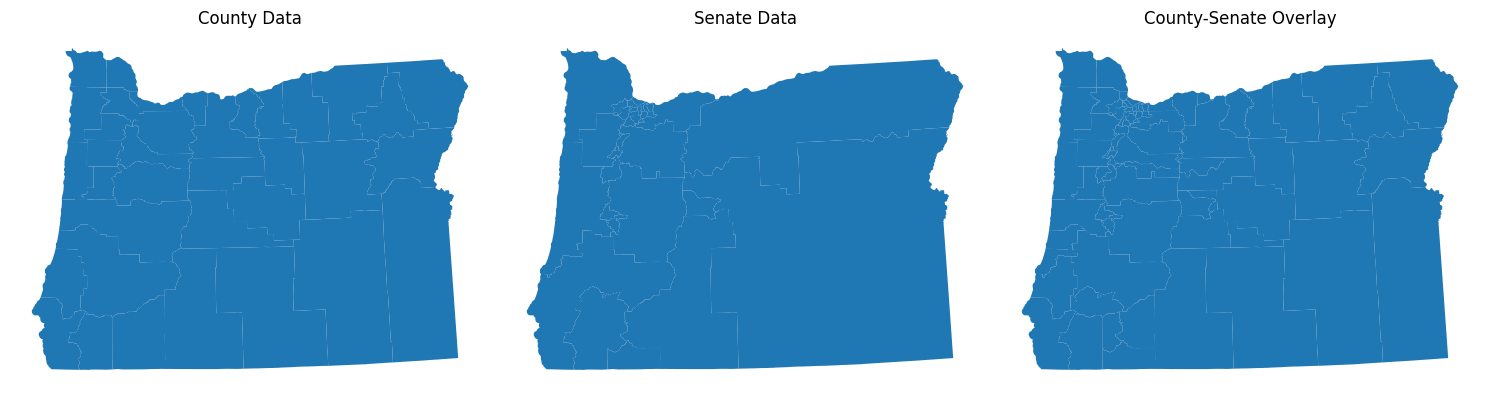

In [42]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each GeoDataFrame in a separate subplot
county_df.plot(ax=axes[0], legend=True)
axes[0].set_title("County Data")
axes[0].axis('off')

sen_df.plot(ax=axes[1], legend=True)
axes[1].set_title("Senate Data")
axes[1].axis('off')

county_sen_overlay_df.plot(ax=axes[2], legend=True)
axes[2].set_title("County-Senate Overlay")
axes[2].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Now we can try to fix the vest20_df the same we did before with sen_df and county_df

In [12]:
vest20_df_repaired_with_county_sen_0 = smart_repair(
    vest20_df,
    snap_precision=8,
    nest_within_regions=county_sen_overlay_df
)

Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.
Identifying overlaps...
Resolving overlaps and filling gaps...


Gaps to fill in region 0: 100%|██████████| 30/30 [00:01<00:00, 22.63it/s]


1 gaps in region 1 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 2: 100%|██████████| 1/1 [00:00<00:00, 32.63it/s]


Found a component of the region at index 2 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 3: 100%|██████████| 168/168 [00:12<00:00, 13.19it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 4 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 5: 100%|██████████| 3/3 [00:00<00:00, 77.66it/s]


Found a component of the region at index 5 that does not intersect any geometry assigned to that region.
Found a component of the region at index 5 that does not intersect any geometry assigned to that region.
Found a component of the region at index 5 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 6:  13%|█▎        | 14/104 [00:00<00:00, 137.63it/s]

Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does no

Gaps to simplify in region 6:  40%|████      | 42/104 [00:00<00:00, 133.12it/s]

Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does no

Gaps to simplify in region 6:  56%|█████▌    | 58/104 [00:00<00:00, 140.81it/s]

Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.


Gaps to simplify in region 6:  70%|███████   | 73/104 [00:00<00:00, 140.05it/s]

Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does no

Gaps to simplify in region 6: 100%|██████████| 104/104 [00:00<00:00, 139.04it/s]


Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does not intersect any geometry assigned to that region.
Found a component of the region at index 6 that does no

Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 8: 100%|██████████| 1/1 [00:00<00:00, 65.81it/s]


Found a component of the region at index 8 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 9 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 10:  40%|████      | 20/50 [00:00<00:00, 196.99it/s]

Found a component of the region at index 10 that does not intersect any geometry assigned to that region.
Found a component of the region at index 10 that does not intersect any geometry assigned to that region.
Found a component of the region at index 10 that does not intersect any geometry assigned to that region.
Found a component of the region at index 10 that does not intersect any geometry assigned to that region.
Found a component of the region at index 10 that does not intersect any geometry assigned to that region.
Found a component of the region at index 10 that does not intersect any geometry assigned to that region.
Found a component of the region at index 10 that does not intersect any geometry assigned to that region.
Found a component of the region at index 10 that does not intersect any geometry assigned to that region.
Found a component of the region at index 10 that does not intersect any geometry assigned to that region.
Found a component of the region at index 10 th

Gaps to simplify in region 10: 100%|██████████| 50/50 [00:00<00:00, 166.08it/s]


Found a component of the region at index 10 that does not intersect any geometry assigned to that region.
Found a component of the region at index 10 that does not intersect any geometry assigned to that region.
Found a component of the region at index 10 that does not intersect any geometry assigned to that region.
Found a component of the region at index 10 that does not intersect any geometry assigned to that region.
Found a component of the region at index 10 that does not intersect any geometry assigned to that region.
Found a component of the region at index 10 that does not intersect any geometry assigned to that region.
Found a component of the region at index 10 that does not intersect any geometry assigned to that region.
Found a component of the region at index 10 that does not intersect any geometry assigned to that region.
Found a component of the region at index 10 that does not intersect any geometry assigned to that region.
Found a component of the region at index 10 th

Gaps to fill: 0it [00:00, ?it/s]


3 gaps in region 11 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 11: 70it [00:02, 31.41it/s]                        
Gaps to fill in region 11: 100%|██████████| 18/18 [00:01<00:00, 14.51it/s]


1 gaps in region 12 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 12: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


2 gaps in region 13 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 13:   3%|▎         | 2/62 [00:00<00:03, 18.26it/s]

Found a component of the region at index

Gaps to simplify in region 13:  15%|█▍        | 9/62 [00:00<00:01, 37.89it/s]

 13 that does not intersect any geometry assigned to that region.


Gaps to simplify in region 14: 100%|██████████| 3/3 [00:00<00:00, 108.85it/s]


Found a component of the region at index 14 that does not intersect any geometry assigned to that region.
Found a component of the region at index 14 that does not intersect any geometry assigned to that region.
Found a component of the region at index 14 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 15: 100%|██████████| 7/7 [00:00<00:00, 86.99it/s]


Found a component of the region at index 15 that does not intersect any geometry assigned to that region.
Found a component of the region at index 15 that does not intersect any geometry assigned to that region.
Found a component of the region at index 15 that does not intersect any geometry assigned to that region.
Found a component of the region at index 15 that does not intersect any geometry assigned to that region.
Found a component of the region at index 15 that does not intersect any geometry assigned to that region.
Found a component of the region at index 15 that does not intersect any geometry assigned to that region.
Found a component of the region at index 15 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 16:  43%|████▎     | 18/42 [00:09<00:09,  2.46it/s]

Found a component of the region at index 16 that does not intersect any geometry assigned to that region.


Gaps to simplify in region 16: 46it [00:29,  1.56it/s]                        
Gaps to simplify in region 17: 100%|██████████| 2/2 [00:00<00:00, 67.42it/s]


Found a component of the region at index 17 that does not intersect any geometry assigned to that region.
Found a component of the region at index 17 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 19: 100%|██████████| 9/9 [00:00<00:00, 172.97it/s]


Found a component of the region at index 19 that does not intersect any geometry assigned to that region.
Found a component of the region at index 19 that does not intersect any geometry assigned to that region.
Found a component of the region at index 19 that does not intersect any geometry assigned to that region.
Found a component of the region at index 19 that does not intersect any geometry assigned to that region.
Found a component of the region at index 19 that does not intersect any geometry assigned to that region.
Found a component of the region at index 19 that does not intersect any geometry assigned to that region.
Found a component of the region at index 19 that does not intersect any geometry assigned to that region.
Found a component of the region at index 19 that does not intersect any geometry assigned to that region.
Found a component of the region at index 19 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]


2 gaps in region 20 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 20:   0%|          | 0/30 [00:00<?, ?it/s]

Found a component of the region at index 20 that does not intersect any geometry assigned to that region.
Found a component of the region at index 20 that does not intersect any geometry assigned to that region.
Found a component of the region at index 20 that does not intersect any geometry assigned to that region.
Found a component of the region at index 20 that does not intersect any geometry assigned to that region.
Found a component of the region at index 20 that does not intersect any geometry assigned to that region.
Found a component of the region at index 20 that does not intersect any geometry assigned to that region.


Gaps to simplify in region 22: 100%|██████████| 1/1 [00:00<00:00, 53.77it/s]


Found a component of the region at index 22 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 24: 100%|██████████| 7/7 [00:00<00:00, 112.06it/s]


Found a component of the region at index 24 that does not intersect any geometry assigned to that region.
Found a component of the region at index 24 that does not intersect any geometry assigned to that region.
Found a component of the region at index 24 that does not intersect any geometry assigned to that region.
Found a component of the region at index 24 that does not intersect any geometry assigned to that region.
Found a component of the region at index 24 that does not intersect any geometry assigned to that region.
Found a component of the region at index 24 that does not intersect any geometry assigned to that region.
Found a component of the region at index 24 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 25: 100%|██████████| 4/4 [00:00<00:00, 76.12it/s]


Found a component of the region at index 25 that does not intersect any geometry assigned to that region.
Found a component of the region at index 25 that does not intersect any geometry assigned to that region.
Found a component of the region at index 25 that does not intersect any geometry assigned to that region.
Found a component of the region at index 25 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 26 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 27: 100%|██████████| 12/12 [00:00<00:00, 43.71it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 28 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 28: 100%|██████████| 4/4 [00:00<00:00, 125.26it/s]


Found a component of the region at index 28 that does not intersect any geometry assigned to that region.
Found a component of the region at index 28 that does not intersect any geometry assigned to that region.
Found a component of the region at index 28 that does not intersect any geometry assigned to that region.
Found a component of the region at index 28 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 29: 100%|██████████| 4/4 [00:00<00:00, 99.84it/s]


Found a component of the region at index 29 that does not intersect any geometry assigned to that region.
Found a component of the region at index 29 that does not intersect any geometry assigned to that region.
Found a component of the region at index 29 that does not intersect any geometry assigned to that region.
Found a component of the region at index 29 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 30 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 31:  25%|██▌       | 29/115 [00:00<00:00, 143.72it/s]

Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 th

Gaps to simplify in region 31:  38%|███▊      | 44/115 [00:00<00:00, 139.32it/s]

Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 th

Gaps to simplify in region 31:  62%|██████▏   | 71/115 [00:00<00:00, 112.59it/s]

Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 th

Gaps to simplify in region 31:  72%|███████▏  | 83/115 [00:00<00:00, 102.09it/s]

Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 th

Gaps to simplify in region 31: 100%|██████████| 115/115 [00:01<00:00, 114.40it/s]


Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 that does not intersect any geometry assigned to that region.
Found a component of the region at index 31 th

Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 32 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 33: 100%|██████████| 1/1 [00:00<00:00, 56.71it/s]


Found a component of the region at index 33 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 34: 100%|██████████| 7/7 [00:00<00:00, 123.94it/s]


Found a component of the region at index 34 that does not intersect any geometry assigned to that region.
Found a component of the region at index 34 that does not intersect any geometry assigned to that region.
Found a component of the region at index 34 that does not intersect any geometry assigned to that region.
Found a component of the region at index 34 that does not intersect any geometry assigned to that region.
Found a component of the region at index 34 that does not intersect any geometry assigned to that region.
Found a component of the region at index 34 that does not intersect any geometry assigned to that region.
Found a component of the region at index 34 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 35: 100%|██████████| 9/9 [00:00<00:00, 114.29it/s]


Found a component of the region at index 35 that does not intersect any geometry assigned to that region.
Found a component of the region at index 35 that does not intersect any geometry assigned to that region.
Found a component of the region at index 35 that does not intersect any geometry assigned to that region.
Found a component of the region at index 35 that does not intersect any geometry assigned to that region.
Found a component of the region at index 35 that does not intersect any geometry assigned to that region.
Found a component of the region at index 35 that does not intersect any geometry assigned to that region.
Found a component of the region at index 35 that does not intersect any geometry assigned to that region.
Found a component of the region at index 35 that does not intersect any geometry assigned to that region.
Found a component of the region at index 35 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 36:   0%|          | 0/2 [00:00<?, ?it/s]

Found a component of the region at index

Gaps to simplify in region 36: 100%|██████████| 2/2 [00:00<00:00, 68.40it/s]


 36 that does not intersect any geometry assigned to that region.
Found a component of the region at index 36 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 37 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 37: 100%|██████████| 189/189 [00:19<00:00,  9.83it/s]


Found a component of the region at index 37 that does not intersect any geometry assigned to that region.
Found a component of the region at index 37 that does not intersect any geometry assigned to that region.
Found a component of the region at index 37 that does not intersect any geometry assigned to that region.
Found a component of the region at index 37 that does not intersect any geometry assigned to that region.
Found a component of the region at index 37 that does not intersect any geometry assigned to that region.
Found a component of the region at index 37 that does not intersect any geometry assigned to that region.
Found a component of the region at index 37 that does not intersect any geometry assigned to that region.
Found a component of the region at index 37 that does not intersect any geometry assigned to that region.
Found a component of the region at index 37 that does not intersect any geometry assigned to that region.
Found a component of the region at index 37 th

Gaps to simplify in region 39: 100%|██████████| 8/8 [00:00<00:00, 132.34it/s]


Found a component of the region at index 39 that does not intersect any geometry assigned to that region.
Found a component of the region at index 39 that does not intersect any geometry assigned to that region.
Found a component of the region at index 39 that does not intersect any geometry assigned to that region.
Found a component of the region at index 39 that does not intersect any geometry assigned to that region.
Found a component of the region at index 39 that does not intersect any geometry assigned to that region.
Found a component of the region at index 39 that does not intersect any geometry assigned to that region.
Found a component of the region at index 39 that does not intersect any geometry assigned to that region.
Found a component of the region at index 39 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]


3 gaps in region 40 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 40: 100%|██████████| 9/9 [00:00<00:00, 19.08it/s]


6 gaps in region 41 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 41: 100%|██████████| 18/18 [00:01<00:00, 16.20it/s]


3 gaps in region 42 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 42: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


1 gaps in region 43 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 43:  91%|█████████ | 39/43 [00:03<00:00, 19.97it/s]

Found a component of the region at index 43 that does not intersect any geometry assigned to that region.
Found a component of the region at index 43 that does not intersect any geometry assigned to that region.


Gaps to fill in region 43: 100%|██████████| 26/26 [00:01<00:00, 20.52it/s]


3 gaps in region 44 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 44:  22%|██▏       | 8/36 [00:00<00:00, 78.86it/s]

Found a component of the region at index 44 that does not intersect any geometry assigned to that region.


Gaps to fill in region 44: 100%|██████████| 9/9 [00:00<00:00, 26.82it/s]


3 gaps in region 45 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 45: 63it [00:08,  7.44it/s]                        
Gaps to fill in region 45: 100%|██████████| 33/33 [00:01<00:00, 22.03it/s]


1 gaps in region 46 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 46: 41it [00:07,  5.45it/s]                        
Gaps to simplify in region 48: 100%|██████████| 2/2 [00:00<00:00, 107.71it/s]


Found a component of the region at index 48 that does not intersect any geometry assigned to that region.
Found a component of the region at index 48 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 49: 100%|██████████| 2/2 [00:00<00:00, 89.54it/s]


Found a component of the region at index 49 that does not intersect any geometry assigned to that region.
Found a component of the region at index 49 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 50: 100%|██████████| 4/4 [00:00<00:00, 128.79it/s]


Found a component of the region at index 50 that does not intersect any geometry assigned to that region.
Found a component of the region at index 50 that does not intersect any geometry assigned to that region.
Found a component of the region at index 50 that does not intersect any geometry assigned to that region.
Found a component of the region at index 50 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 52:  13%|█▎        | 38/289 [00:02<00:11, 21.80it/s]

Found a component of the region at index 52 that does not intersect any geometry assigned to that region.


Gaps to fill in region 52: 100%|██████████| 24/24 [01:04<00:00,  2.70s/it]


1 gaps in region 53 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 54: 100%|██████████| 73/73 [00:04<00:00, 16.67it/s]


Found a component of the region at index 54 that does not intersect any geometry assigned to that region.
Found a component of the region at index 54 that does not intersect any geometry assigned to that region.


Gaps to fill in region 54: 100%|██████████| 13/13 [00:01<00:00,  6.60it/s]


3 gaps in region 55 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 55: 100%|██████████| 19/19 [00:02<00:00,  7.33it/s]


1 gaps in region 56 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 57: 100%|██████████| 1/1 [00:00<00:00, 142.79it/s]


Found a component of the region at index 57 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]


2 gaps in region 58 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 58: 100%|██████████| 4/4 [00:00<00:00, 24.10it/s]


1 gaps in region 59 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 60:  46%|████▌     | 12/26 [00:00<00:00, 39.45it/s]

Found a component of the region at index 60 that does not intersect any geometry assigned to that region.
Found a component of the region at index 60 that does not intersect any geometry assigned to that region.
Found a component of the region at index 60 that does not intersect any geometry assigned to that region.
Found a component of the region at index 60 that does not intersect any geometry assigned to that region.
Found a component of the region at index 60 that does not intersect any geometry assigned to that region.
Found a component of the region at index 60 that does not intersect any geometry assigned to that region.


Gaps to simplify in region 60:  62%|██████▏   | 16/26 [00:00<00:00, 20.31it/s]

Found a component of the region at index 60 that does not intersect any geometry assigned to that region.
Found a component of the region at index 60 that does not intersect any geometry assigned to that region.
Found a component of the region at index 60 that does not intersect any geometry assigned to that region.


Gaps to simplify in region 60: 100%|██████████| 26/26 [00:01<00:00, 15.41it/s]


Found a component of the region at index 60 that does not intersect any geometry assigned to that region.
Found a component of the region at index 60 that does not intersect any geometry assigned to that region.
Found a component of the region at index 60 that does not intersect any geometry assigned to that region.
Found a component of the region at index 60 that does not intersect any geometry assigned to that region.
Found a component of the region at index 60 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]


2 gaps in region 61 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 62:  53%|█████▎    | 19/36 [00:00<00:00, 189.06it/s]

Found a component of the region at index 62 that does not intersect any geometry assigned to that region.
Found a component of the region at index 62 that does not intersect any geometry assigned to that region.
Found a component of the region at index 62 that does not intersect any geometry assigned to that region.
Found a component of the region at index 62 that does not intersect any geometry assigned to that region.
Found a component of the region at index 62 that does not intersect any geometry assigned to that region.
Found a component of the region at index 62 that does not intersect any geometry assigned to that region.
Found a component of the region at index 62 that does not intersect any geometry assigned to that region.
Found a component of the region at index 62 that does not intersect any geometry assigned to that region.
Found a component of the region at index 62 that does not intersect any geometry assigned to that region.
Found a component of the region at index 62 th

Gaps to simplify in region 62: 100%|██████████| 36/36 [00:00<00:00, 187.27it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 63: 100%|██████████| 20/20 [00:00<00:00, 149.94it/s]


Found a component of the region at index 63 that does not intersect any geometry assigned to that region.
Found a component of the region at index 63 that does not intersect any geometry assigned to that region.
Found a component of the region at index 63 that does not intersect any geometry assigned to that region.
Found a component of the region at index 63 that does not intersect any geometry assigned to that region.
Found a component of the region at index 63 that does not intersect any geometry assigned to that region.
Found a component of the region at index 63 that does not intersect any geometry assigned to that region.
Found a component of the region at index 63 that does not intersect any geometry assigned to that region.
Found a component of the region at index 63 that does not intersect any geometry assigned to that region.
Found a component of the region at index 63 that does not intersect any geometry assigned to that region.
Found a component of the region at index 63 th

Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 64: 398it [04:27,  1.49it/s]                           
Gaps to simplify in region 65: 100%|██████████| 6/6 [00:00<00:00, 100.04it/s]


Found a component of the region at index 65 that does not intersect any geometry assigned to that region.
Found a component of the region at index 65 that does not intersect any geometry assigned to that region.
Found a component of the region at index 65 that does not intersect any geometry assigned to that region.
Found a component of the region at index 65 that does not intersect any geometry assigned to that region.
Found a component of the region at index 65 that does not intersect any geometry assigned to that region.
Found a component of the region at index 65 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 67: 100%|██████████| 2/2 [00:00<00:00, 73.02it/s]


Found a component of the region at index 67 that does not intersect any geometry assigned to that region.
Found a component of the region at index 67 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 68: 100%|██████████| 2/2 [00:00<00:00, 125.23it/s]


Found a component of the region at index 68 that does not intersect any geometry assigned to that region.
Found a component of the region at index 68 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 69 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 69: 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


1 gaps in region 70 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 70: 100%|██████████| 21/21 [00:01<00:00, 19.44it/s]


1 gaps in region 71 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 71: 100%|██████████| 35/35 [00:02<00:00, 14.82it/s]


1 gaps in region 72 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 72:  44%|████▍     | 4/9 [00:00<00:00, 37.48it/s]

Found a component of the region at index 72 that does not intersect any geometry assigned to that region.


Gaps to simplify in region 72: 11it [00:02,  3.71it/s]                      
Gaps to simplify in region 73: 100%|██████████| 4/4 [00:00<00:00, 169.16it/s]


Found a component of the region at index 73 that does not intersect any geometry assigned to that region.
Found a component of the region at index 73 that does not intersect any geometry assigned to that region.
Found a component of the region at index 73 that does not intersect any geometry assigned to that region.
Found a component of the region at index 73 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 74: 100%|██████████| 1/1 [00:00<00:00, 42.76it/s]


2 gaps in region 75 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 75: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


1 gaps in region 76 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 77: 100%|██████████| 2/2 [00:00<00:00, 80.05it/s]


Found a component of the region at index 77 that does not intersect any geometry assigned to that region.
Found a component of the region at index 77 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]


2 gaps in region 78 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 78:   0%|          | 0/15 [00:00<?, ?it/s]

Found a component of the region at index 78 that does not intersect any geometry assigned to that region.
Found a component of the region at index 78 that does not intersect any geometry assigned to that region.


Gaps to simplify in region 78:  40%|████      | 6/15 [00:00<00:00, 29.21it/s]

Found a component of the region at index 78 that does not intersect any geometry assigned to that region.


Gaps to fill in region 78: 100%|██████████| 10/10 [00:00<00:00, 57.40it/s]


2 gaps in region 79 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 79: 100%|██████████| 14/14 [00:00<00:00, 56.84it/s]


4 gaps in region 80 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 80: 37it [00:01, 25.54it/s]                        
Gaps to fill in region 80: 100%|██████████| 12/12 [00:00<00:00, 36.34it/s]


2 gaps in region 81 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 81: 100%|██████████| 12/12 [00:00<00:00, 34.43it/s]


2 gaps in region 82 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 82: 51it [00:03, 13.35it/s]                        
Gaps to simplify in region 84:  12%|█▏        | 17/140 [00:00<00:00, 166.18it/s]

Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 th

Gaps to simplify in region 84:  39%|███▊      | 54/140 [00:00<00:00, 161.72it/s]

Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 th

Gaps to simplify in region 84:  64%|██████▎   | 89/140 [00:00<00:00, 160.98it/s]

Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 th

Gaps to simplify in region 84:  89%|████████▉ | 125/140 [00:00<00:00, 163.38it/s]

Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 that does not intersect any geometry assigned to that region.
Found a component of the region at index 84 th

Gaps to simplify in region 84: 100%|██████████| 140/140 [00:00<00:00, 164.17it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 85: 100%|██████████| 37/37 [00:00<00:00, 38.10it/s]


1 gaps in region 86 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 87: 100%|██████████| 8/8 [00:00<00:00, 117.74it/s]


Found a component of the region at index 87 that does not intersect any geometry assigned to that region.
Found a component of the region at index 87 that does not intersect any geometry assigned to that region.
Found a component of the region at index 87 that does not intersect any geometry assigned to that region.
Found a component of the region at index 87 that does not intersect any geometry assigned to that region.
Found a component of the region at index 87 that does not intersect any geometry assigned to that region.
Found a component of the region at index 87 that does not intersect any geometry assigned to that region.
Found a component of the region at index 87 that does not intersect any geometry assigned to that region.
Found a component of the region at index 87 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 88 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 88:  48%|████▊     | 95/198 [00:05<00:03, 26.08it/s]

Found a component of the region at index 88 that does not intersect any geometry assigned to that region.


Gaps to fill in region 88: 100%|██████████| 34/34 [00:01<00:00, 27.95it/s]


1 gaps in region 89 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 89: 100%|██████████| 7/7 [00:00<00:00, 60.31it/s]


Found a component of the region at index 89 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 90: 100%|██████████| 9/9 [00:00<00:00, 14.43it/s]
Gaps to simplify in region 91: 589it [01:11,  8.29it/s]                         
Gaps to fill in region 91: 100%|██████████| 103/103 [00:04<00:00, 20.81it/s]


2 gaps in region 92 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 92:  79%|███████▊  | 37/47 [00:00<00:00, 32.22it/s]

Found a component of the region at index 92 that does not intersect any geometry assigned to that region.


Gaps to fill in region 92: 100%|██████████| 17/17 [00:01<00:00, 10.13it/s]


4 gaps in region 93 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 93: 66it [00:02, 30.51it/s]                        
Gaps to simplify in region 94: 100%|██████████| 11/11 [00:00<00:00, 163.48it/s]


Found a component of the region at index 94 that does not intersect any geometry assigned to that region.
Found a component of the region at index 94 that does not intersect any geometry assigned to that region.
Found a component of the region at index 94 that does not intersect any geometry assigned to that region.
Found a component of the region at index 94 that does not intersect any geometry assigned to that region.
Found a component of the region at index 94 that does not intersect any geometry assigned to that region.
Found a component of the region at index 94 that does not intersect any geometry assigned to that region.
Found a component of the region at index 94 that does not intersect any geometry assigned to that region.
Found a component of the region at index 94 that does not intersect any geometry assigned to that region.
Found a component of the region at index 94 that does not intersect any geometry assigned to that region.
Found a component of the region at index 94 th

Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 95: 100%|██████████| 5/5 [00:00<00:00, 123.86it/s]


Found a component of the region at index 95 that does not intersect any geometry assigned to that region.
Found a component of the region at index 95 that does not intersect any geometry assigned to that region.
Found a component of the region at index 95 that does not intersect any geometry assigned to that region.
Found a component of the region at index 95 that does not intersect any geometry assigned to that region.
Found a component of the region at index 95 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 96 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 96:   0%|          | 0/34 [00:00<?, ?it/s]

Found a component of the region at index 96 that does not intersect any geometry assigned to that region.


Gaps to simplify in region 96:  82%|████████▏ | 28/34 [00:00<00:00, 52.72it/s]

Found a component of the region at index 96 that does not intersect any geometry assigned to that region.
Found a component of the region at index 96 that does not intersect any geometry assigned to that region.


Gaps to simplify in region 96: 100%|██████████| 34/34 [00:01<00:00, 22.05it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 97:  28%|██▊       | 11/40 [00:00<00:00, 101.79it/s]

Found a component of the region at index 97 that does not intersect any geometry assigned to that region.
Found a component of the region at index 97 that does not intersect any geometry assigned to that region.
Found a component of the region at index 97 that does not intersect any geometry assigned to that region.
Found a component of the region at index 97 that does not intersect any geometry assigned to that region.
Found a component of the region at index 97 that does not intersect any geometry assigned to that region.
Found a component of the region at index 97 that does not intersect any geometry assigned to that region.
Found a component of the region at index 97 that does not intersect any geometry assigned to that region.
Found a component of the region at index 97 that does not intersect any geometry assigned to that region.
Found a component of the region at index 97 that does not intersect any geometry assigned to that region.
Found a component of the region at index 97 th

Gaps to simplify in region 97: 100%|██████████| 40/40 [00:00<00:00, 123.54it/s]


Found a component of the region at index 97 that does not intersect any geometry assigned to that region.
Found a component of the region at index 97 that does not intersect any geometry assigned to that region.
Found a component of the region at index 97 that does not intersect any geometry assigned to that region.
Found a component of the region at index 97 that does not intersect any geometry assigned to that region.
Found a component of the region at index 97 that does not intersect any geometry assigned to that region.
Found a component of the region at index 97 that does not intersect any geometry assigned to that region.
Found a component of the region at index 97 that does not intersect any geometry assigned to that region.
Found a component of the region at index 97 that does not intersect any geometry assigned to that region.
Found a component of the region at index 97 that does not intersect any geometry assigned to that region.
Found a component of the region at index 97 th

Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 98: 100%|██████████| 6/6 [00:00<00:00, 15.94it/s]


1 gaps in region 99 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 100: 100%|██████████| 1/1 [00:00<00:00, 86.03it/s]


Found a component of the region at index 100 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 101 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 102: 100%|██████████| 8/8 [00:00<00:00, 153.57it/s]


Found a component of the region at index 102 that does not intersect any geometry assigned to that region.
Found a component of the region at index 102 that does not intersect any geometry assigned to that region.
Found a component of the region at index 102 that does not intersect any geometry assigned to that region.
Found a component of the region at index 102 that does not intersect any geometry assigned to that region.
Found a component of the region at index 102 that does not intersect any geometry assigned to that region.
Found a component of the region at index 102 that does not intersect any geometry assigned to that region.
Found a component of the region at index 102 that does not intersect any geometry assigned to that region.
Found a component of the region at index 102 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]


3 gaps in region 103 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 103: 100%|██████████| 48/48 [00:00<00:00, 59.27it/s]


1 gaps in region 104 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 104: 100%|██████████| 4/4 [00:00<00:00, 28.65it/s]


2 gaps in region 105 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 105:   6%|▌         | 7/118 [00:00<00:01, 61.93it/s]

Found a component of the region at index 105 that does not intersect any geometry assigned to that region.


Gaps to simplify in region 106: 100%|██████████| 2/2 [00:00<00:00, 141.65it/s]


Found a component of the region at index 106 that does not intersect any geometry assigned to that region.
Found a component of the region at index 106 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 107: 100%|██████████| 9/9 [00:00<00:00, 90.84it/s]


Found a component of the region at index 107 that does not intersect any geometry assigned to that region.
Found a component of the region at index 107 that does not intersect any geometry assigned to that region.
Found a component of the region at index 107 that does not intersect any geometry assigned to that region.
Found a component of the region at index 107 that does not intersect any geometry assigned to that region.
Found a component of the region at index 107 that does not intersect any geometry assigned to that region.
Found a component of the region at index 107 that does not intersect any geometry assigned to that region.
Found a component of the region at index 107 that does not intersect any geometry assigned to that region.
Found a component of the region at index 107 that does not intersect any geometry assigned to that region.
Found a component of the region at index 107 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 108: 100%|██████████| 1/1 [00:00<00:00, 47.76it/s]


Found a component of the region at index 108 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 109:   0%|          | 0/13 [00:00<?, ?it/s]

Found a component of the region at index 109 that does not intersect any geometry assigned to that region.
Found a component of the region at index 109 that does not intersect any geometry assigned to that region.
Found a component of the region at index 109 that does not intersect any geometry assigned to that region.
Found a component of the region at index 109 that does not intersect any geometry assigned to that region.
Found a component of the region at index 109 that does not intersect any geometry assigned to that region.


Gaps to simplify in region 109: 100%|██████████| 13/13 [00:00<00:00, 78.90it/s]

Found a component of the region at index 109 that does not intersect any geometry assigned to that region.
Found a component of the region at index 109 that does not intersect any geometry assigned to that region.
Found a component of the region at index 109 that does not intersect any geometry assigned to that region.
Found a component of the region at index 109 that does not intersect any geometry assigned to that region.
Found a component of the region at index 109 that does not intersect any geometry assigned to that region.
Found a component of the region at index 109 that does not intersect any geometry assigned to that region.
Found a component of the region at index 109 that does not intersect any geometry assigned to that region.
Found a component of the region at index 109 that does not intersect any geometry assigned to that region.



Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 110: 100%|██████████| 6/6 [00:00<00:00, 107.70it/s]

Found a component of the region at index 110 that does not intersect any geometry assigned to that region.
Found a component of the region at index 110 that does not intersect any geometry assigned to that region.
Found a component of the region at index 110 that does not intersect any geometry assigned to that region.
Found a component of the region at index 110 that does not intersect any geometry assigned to that region.
Found a component of the region at index 110 that does not intersect any geometry assigned to that region.
Found a component of the region at index 110 that does not intersect any geometry assigned to that region.



Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 113: 100%|██████████| 17/17 [00:00<00:00, 135.55it/s]


Found a component of the region at index 113 that does not intersect any geometry assigned to that region.
Found a component of the region at index 113 that does not intersect any geometry assigned to that region.
Found a component of the region at index 113 that does not intersect any geometry assigned to that region.
Found a component of the region at index 113 that does not intersect any geometry assigned to that region.
Found a component of the region at index 113 that does not intersect any geometry assigned to that region.
Found a component of the region at index 113 that does not intersect any geometry assigned to that region.
Found a component of the region at index 113 that does not intersect any geometry assigned to that region.
Found a component of the region at index 113 that does not intersect any geometry assigned to that region.
Found a component of the region at index 113 that does not intersect any geometry assigned to that region.
Found a component of the region at in

Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 114 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 115: 100%|██████████| 1/1 [00:00<00:00, 42.38it/s]


Found a component of the region at index 115 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 116: 100%|██████████| 4/4 [00:00<00:00, 67.13it/s]


Found a component of the region at index 116 that does not intersect any geometry assigned to that region.
Found a component of the region at index 116 that does not intersect any geometry assigned to that region.
Found a component of the region at index 116 that does not intersect any geometry assigned to that region.
Found a component of the region at index 116 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 117 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 118: 100%|██████████| 9/9 [00:00<00:00, 114.88it/s]


Found a component of the region at index 118 that does not intersect any geometry assigned to that region.
Found a component of the region at index 118 that does not intersect any geometry assigned to that region.
Found a component of the region at index 118 that does not intersect any geometry assigned to that region.
Found a component of the region at index 118 that does not intersect any geometry assigned to that region.
Found a component of the region at index 118 that does not intersect any geometry assigned to that region.
Found a component of the region at index 118 that does not intersect any geometry assigned to that region.
Found a component of the region at index 118 that does not intersect any geometry assigned to that region.
Found a component of the region at index 118 that does not intersect any geometry assigned to that region.
Found a component of the region at index 118 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]


6 gaps in region 119 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 119: 66it [00:32,  2.02it/s]                        
Gaps to fill in region 119: 100%|██████████| 17/17 [00:02<00:00,  7.02it/s]


1 gaps in region 120 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 120: 100%|██████████| 29/29 [00:03<00:00,  7.95it/s]


2 gaps in region 121 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 121: 414it [00:58,  7.12it/s]                         
Gaps to fill in region 121: 100%|██████████| 88/88 [00:06<00:00, 14.09it/s]


2 gaps in region 122 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 122: 324it [00:44,  7.26it/s]                         
Gaps to simplify in region 123: 100%|██████████| 16/16 [00:00<00:00, 117.11it/s]


Found a component of the region at index 123 that does not intersect any geometry assigned to that region.
Found a component of the region at index 123 that does not intersect any geometry assigned to that region.
Found a component of the region at index 123 that does not intersect any geometry assigned to that region.
Found a component of the region at index 123 that does not intersect any geometry assigned to that region.
Found a component of the region at index 123 that does not intersect any geometry assigned to that region.
Found a component of the region at index 123 that does not intersect any geometry assigned to that region.
Found a component of the region at index 123 that does not intersect any geometry assigned to that region.
Found a component of the region at index 123 that does not intersect any geometry assigned to that region.
Found a component of the region at index 123 that does not intersect any geometry assigned to that region.
Found a component of the region at in

Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 124:   0%|          | 0/48 [00:00<?, ?it/s]

Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.


Gaps to simplify in region 124:  21%|██        | 10/48 [00:00<00:00, 92.04it/s]

Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at in

Gaps to simplify in region 124:  42%|████▏     | 20/48 [00:00<00:00, 84.93it/s]

Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.


Gaps to simplify in region 124:  60%|██████    | 29/48 [00:00<00:00, 74.40it/s]

Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at in

Gaps to simplify in region 124: 100%|██████████| 48/48 [00:00<00:00, 81.14it/s]


Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at index 124 that does not intersect any geometry assigned to that region.
Found a component of the region at in

Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 125 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 126:  17%|█▋        | 30/178 [00:00<00:00, 149.61it/s]

Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at in

Gaps to simplify in region 126:  25%|██▌       | 45/178 [00:00<00:00, 134.64it/s]

Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at in

Gaps to simplify in region 126:  51%|█████     | 90/178 [00:00<00:00, 141.05it/s]

Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at in

Gaps to simplify in region 126:  70%|██████▉   | 124/178 [00:00<00:00, 154.01it/s]

Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at in

Gaps to simplify in region 126:  79%|███████▊  | 140/178 [00:00<00:00, 138.43it/s]

Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at in

Gaps to simplify in region 126: 100%|██████████| 178/178 [00:01<00:00, 140.91it/s]

Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at index 126 that does not intersect any geometry assigned to that region.
Found a component of the region at in


Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 127 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 127:   4%|▎         | 13/362 [00:00<00:03, 114.36it/s]

Found a component of the region at index 127 that does not intersect any geometry assigned to that region.
Found a component of the region at index 127 that does not intersect any geometry assigned to that region.
Found a component of the region at index 127 that does not intersect any geometry assigned to that region.
Found a component of the region at index 127 that does not intersect any geometry assigned to that region.
Found a component of the region at index 127 that does not intersect any geometry assigned to that region.
Found a component of the region at index 127 that does not intersect any geometry assigned to that region.
Found a component of the region at index 127 that does not intersect any geometry assigned to that region.
Found a component of the region at index 127 that does not intersect any geometry assigned to that region.
Found a component of the region at index 127 that does not intersect any geometry assigned to that region.
Found a component of the region at in

Gaps to fill in region 127: 100%|██████████| 37/37 [00:06<00:00,  6.04it/s]


1 gaps in region 128 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 128: 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


1 gaps in region 129 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 129: 100%|██████████| 24/24 [00:00<00:00, 25.98it/s]


Found a component of the region at index 129 that does not intersect any geometry assigned to that region.
Found a component of the region at index 129 that does not intersect any geometry assigned to that region.
Found a component of the region at index 129 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 130: 100%|██████████| 5/5 [00:00<00:00, 98.88it/s]


Found a component of the region at index 130 that does not intersect any geometry assigned to that region.
Found a component of the region at index 130 that does not intersect any geometry assigned to that region.
Found a component of the region at index 130 that does not intersect any geometry assigned to that region.
Found a component of the region at index 130 that does not intersect any geometry assigned to that region.
Found a component of the region at index 130 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 131:   0%|          | 0/39 [00:00<?, ?it/s]

Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.


Gaps to simplify in region 131:  10%|█         | 4/39 [00:00<00:00, 39.00it/s]

Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at in

Gaps to simplify in region 131:  46%|████▌     | 18/39 [00:00<00:00, 83.22it/s]

Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.


Gaps to simplify in region 131:  72%|███████▏  | 28/39 [00:00<00:00, 85.71it/s]

Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at index 131 that does not intersect any geometry assigned to that region.
Found a component of the region at in

Gaps to simplify in region 131: 100%|██████████| 39/39 [00:00<00:00, 85.83it/s]


Found a component of the region at index 131 that does not intersect any geometry assigned to that region.


Gaps to fill: 0it [00:00, ?it/s]


Assign the population data to the precincts using MAUP and geometry intersection.<br>
For all the new repaired dataframes.

In [16]:
print("Assigning pop to vest20_df_repaired_with_county_sen_0")
utilities.assign_population_data_to(
    vest20_df_repaired_with_county_sen_0,
    population_df,
    vap_df,
    pop_column_names,
    vap_column_names
)

Assigning pop to vest20_df_repaired_with_county_sen_0


Check if any people got missed by the assignment.

In [18]:
print("Checking population for sen to vest20_df_repaired_with_county_sen_0")

print("Total pop:\t", population_df['P0020001'].sum())
print("Actual pop:\t", vest20_df_repaired_with_county_sen_0['P0020001'].sum())
print("Total vap:\t", vap_df['P0040001'].sum())
print("Actual vap:\t", vest20_df_repaired_with_county_sen_0['P0040001'].sum())

Checking population for sen to vest20_df_repaired_with_county_sen_0
Total pop:	 4237256
Actual pop:	 4175964.0
Total vap:	 3370652
Actual vap:	 3320750.0


| Missing People in:                   | POP   | VAP   |
|--------------------------------------|-------|-------|
| vest20_df_repaired_with_county_0     | 32    | 27    |
| vest20_df_repaired_with_sen_0        | 61725 | 50290 |
| vest20_df_repaired_with_county_sen_0 | 61292 | 49902 |


Ok at this point I am going to stop.